<a href="https://colab.research.google.com/github/Oussamayousre/DLL/blob/version_2/drowsiness_project/feature_extraction_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
mem = []
while True:
    mem.append(' ' * 10**6)

In [ ]:
from google.colab.patches import cv2_imshow
from scipy.spatial import distance as dist
from imutils.video import FileVideoStream
from scipy.signal import argrelextrema
from imutils.video import VideoStream
from imutils import face_utils
import numpy as np
import argparse
import imutils
import time
import dlib
import cv2
import os

In [ ]:
def eye_aspect_ratio(eye):
	# compute the euclidean distances between the two sets of
	# vertical eye landmarks (x, y)-coordinates
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
	# compute the euclidean distance between the horizontal
	# eye landmark (x, y)-coordinates
	C = dist.euclidean(eye[0], eye[3])
	# compute the eye aspect ratio
	ear = (A + B) / (2.0 * C)
	# return the eye aspect ratio
	return ear


def start_check(blink_index_list, ear) :
  start = np.array([] , dtype=np.int64)
  Bool = True 
  for i in blink_index_list : 
    Bool = True 
    j = i -1
    while Bool and  j > 0 : 
      if ear[j] <= ear[j-1]  :
        j -= 1
      else : 
        start = np.append(start,j)
        Bool = False 
    #this condition is to make sure that we can save the end value even if it is that last value , since in the while condition
    #we're going to stop before the last value to avoid the index out of bounds error
    if j == 0 : 
      start  = np.append(start , j)
  return start 

def end_check(blink_index_list, ear) :
  
  end = np.array([] , dtype=np.int64)
  Bool = True 
  for i in blink_index_list : 
    Bool = True 
    j = i+1 

    while Bool and j< len(ear)-1 : 
      if ear[j] <= ear[j+1] :

        j += 1
      else : 
        end  = np.append(end , j)
        Bool = False 
    #this condition is to make sure that we can save the end value even if it is that last value , since in the while condition
    #we're going to stop before the last value to avoid the index out of bounds error
    if j == len(ear)-1 : 
      end  = np.append(end , j)
      
  return end  

In [ ]:
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 3
train_blink_Final_1 = np.array([]).reshape(0,4)
labels_blink_Final_1 =  np.array([]).reshape(0,1)
# initialize the frame counters and the total number of blinks
COUNTER = 0
TOTAL = 0
EAR = []
i = 0

In [ ]:
!wget   http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

--2021-07-28 00:06:54--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  55.1MB/s    in 1.1s    

2021-07-28 00:06:55 (55.1 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!bunzip2 /content/shape_predictor_68_face_landmarks.dat.bz2

datFile =  "/content/shape_predictor_68_face_landmarks.dat"

bunzip2: Output file /content/shape_predictor_68_face_landmarks.dat already exists.


In [ ]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(datFile)


In [ ]:
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]

In [ ]:
print("[INFO] starting video stream thread...")
#vs = cv2.VideoCapture("/content/gdrive/MyDrive/DataBase/Fold1_part1/02/0.mov")
fileStream = True
# vs = VideoStream(src=0).start()
# vs = VideoStream(usePiCamera=True).start()
# fileStream = False
time.sleep(1.0)

[INFO] starting video stream thread...


In [ ]:


arr = os.listdir("/content/gdrive/MyDrive/DataBase/Fold1_part1")

for path_1 in arr : 
  #verify if the path is a directory or just a hidden file
  full_path_1 = f"/content/gdrive/MyDrive/DataBase/Fold1_part1/{path_1}"
  isDirectory = os.path.isdir(full_path_1)
  if isDirectory : 
    arr_1 = os.listdir(full_path_1)
    for path_2 in arr_1 : 
      label = int(os.path.splitext(path_2)[0])
      full_path_2 = f"/content/gdrive/MyDrive/DataBase/Fold1_part1/{path_1}/{path_2}"
      vs = cv2.VideoCapture(full_path_2)
    #else  : break #end of array
      i = 0
      while True: 
          # if this is a file video stream, then we need to check if
          # there any more frames left in the buffer to process
          #if not vs.more():
          #	break
          # grab the frame from the threaded video file stream, resize
          # it, and convert it to grayscale
          # channels)
          #frame = vs.read()
          ret, frame = vs.read()
          if ret == False:
            break 
          #print('Original Dimensions : ',frame.shape)
          scale_percent = 60 # percent of original size
          width = int(frame.shape[1] * scale_percent / 100)
          height = int(frame.shape[0] * scale_percent / 100)
          dim = (width, height)  
          # resize image
          frame = cv2.resize(frame, dim, interpolation = cv2.INTER_AREA)
          i+=1
          print(i)
          #
          #frame = imutils.resize(frame, width=450)
          gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
          # detect faces in the grayscale frame
          rects = detector(gray, 0)
          for rect in rects:
          
              # determine the facial landmarks for the face region, then
              # convert the facial landmark (x, y)-coordinates to a NumPy
              # array
              shape = predictor(gray, rect)
              shape = face_utils.shape_to_np(shape)
              # extract the left and right eye coordinates, then use the
              # coordinates to compute the eye aspect ratio for both eyes
              leftEye = shape[lStart:lEnd]
              rightEye = shape[rStart:rEnd]
              leftEAR = eye_aspect_ratio(leftEye)
              rightEAR = eye_aspect_ratio(rightEye)
              # average the eye aspect ratio together for both eyes
              EAR.append((leftEAR + rightEAR) / 2.0 )
          
              if (leftEAR + rightEAR) / 2.0 < EYE_AR_THRESH:
                  COUNTER += 1
              # otherwise, the eye aspect ratio is not below the blink
              # threshold
              else:
                  # if the eyes were closed for a sufficient number of
                  # then increment the total number of blinks
                  if COUNTER >= EYE_AR_CONSEC_FRAMES:
                      TOTAL += 1
                  # reset the eye frame counter
                  COUNTER = 0
              # draw the total number of blinks on the frame along with
              # the computed eye aspect ratio for the frame
              #cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30),
              #cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
              #cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
              #cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
              # show the frame
          #cv2_imshow(cv2_imshow(cv2.resize(frame, (800, 600))))
      ear = np.array(EAR)
      ear.reshape(ear.shape[0])
      #find the min peak of blinks 
      index_peak = argrelextrema(ear, np.less)
      index_peak = np.asarray(index_peak)[0] 
      index_peak_blink = np.array([])
      #key = cv2.waitKey(1) & 0xFF
      for i in index_peak :
        if EAR[i] < 0.3 :
          index_peak_blink = np.append(index_peak_blink , i)

      index_peak_blink = index_peak_blink.astype(np.int64)
      #start of blinks
      start = start_check(index_peak_blink,ear) 
      #end of blinks
      end = end_check(index_peak_blink,ear )
      #duration of blinks
      Duration = end - start + 1

      Am = ear[end] - 2*ear[index_peak_blink] + ear[start] 
      #amplitude of blinks 
      Ampl = Am / (end - start)
      #velocity of blinks
      Eye_Open_Speed = (ear[end] - ear[index_peak_blink])/(end - index_peak_blink )
          
      Frames_nmbr = np.arange(1 , len(ear)+1)
      #frequency of blinks 
      Freq = 100*(np.arange(1 , len(index_peak_blink)+1)/Frames_nmbr[end])  

      train_blink_Final_1 = np.vstack([train_blink_Final_1, np.column_stack((Duration, Ampl,Eye_Open_Speed,Freq))])
      labels_blink_Final_1 = np.vstack([labels_blink_Final_1, np.full((len(Freq),1), label)])

#train classes 
np.save('/content/gdrive/MyDrive/DataBase/Fold1_part1/train_blink_1.npy', train_blink_Final_1) # save
#train labels
np.save('/content/gdrive/MyDrive/DataBase/Fold1_part1/labels_blink_1.npy', labels_blink_Final_1) # save

    # if the `q` key was pressed, break from the loop
    #if key == ord("q"):
    #	break
# do a bit of cleanup
#cv2.destroyAllWindows()
#vs.stop()


In [ ]:
print(len(EAR))

23769


In [ ]:
ear = np.array(EAR)
print(len(EAR))
ear.reshape(ear.shape[0])
np.arange(1, 20,1/len(EAR))

18229


array([ 1.        ,  1.00005486,  1.00010972, ..., 19.99983543,
       19.99989028, 19.99994514])

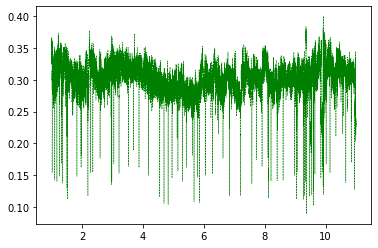

In [ ]:
import matplotlib.pyplot as plt
plt.plot(np.arange(1, 11,10/len(EAR)),ear, color='green', linestyle='dashed', linewidth =0.5,
          markerfacecolor='blue', markersize=2)

In [ ]:
ear

array([0.32557935, 0.36006933, 0.33832019, ..., 0.22591845, 0.23827683,
       0.23272271])

In [ ]:
list(ear[16::])

## in this part of code i was making sure that everything works fine  ( dim's shape , blink life cycle ... )

In [ ]:
from scipy.signal import argrelextrema

index_peak = argrelextrema(ear, np.less)
index_peak = np.asarray(index_peak)[0]
index_peak


(array([    2,     8,    13, ..., 18218, 18221, 18226]),)

In [ ]:
index_peak_blink = np.array([])


In [ ]:
for i in index_peak : 
  
  if EAR[i] < 0.3 : 
    
    index_peak_blink = np.append(index_peak_blink , i)
index_peak_blink = index_peak_blink.astype(np.int64)
len(index_peak_blink)

3467

In [ ]:
def start_check(blink_index_list, ear) :
  start = np.array([] , dtype=np.int64)
  Bool = True 
  for i in blink_index_list : 
    Bool = True 
    j = i -1
    while Bool : 
      if ear[j] <= ear[j-1] :
        
        j -= 1

      else : 
       
        start = np.append(start,j)
        Bool = False 
  return start 
#start = np.array(start_check(index_peak_blink,EAR))
start = start_check(index_peak_blink,ear)  
start 



array([   16,    18,    20, ..., 18215, 18220, 18224])

In [ ]:
def end_check(blink_index_list, ear) :
  
  end = np.array([] , dtype=np.int64)
  Bool = True 
  for i in blink_index_list : 
    Bool = True 
    j = i+1
    while Bool and j<len(ear)-1 : 
      if ear[j] <= ear[j+1] :

        j += 1

      else : 
        end  = np.append(end , j)
        Bool = False 
  return end 
end = end_check(index_peak_blink,ear )
end
  

array([   18,    20,    24, ..., 18220, 18224, 18227])

In [ ]:
Duration = end - start + 1
Duration

array([3, 3, 5, ..., 6, 5, 4])

In [ ]:
Am = ear[end] - 2*ear[index_peak_blink] + ear[start] 
Ampl = Am / (end - start)
Ampl

array([0.03827348, 0.01494886, 0.0059184 , ..., 0.00857088, 0.01046092,
       0.00621951])

In [ ]:
ear[end]

array([0.31412308, 0.29932112, 0.30457552, ..., 0.23789934, 0.2322186 ,
       0.23827683])

In [ ]:
Eye_Open_Speed = (ear[end] - ear[index_peak_blink])/(end - index_peak_blink )

In [ ]:
Frames_nmbr = np.arange(1 , len(ear)+1)
Freq = 100*(np.arange(1 , len(index_peak_blink)+1)/Frames_nmbr[end])
len(Freq)

3467

In [ ]:
train_blink_1 = np.column_stack((Duration, Ampl,Eye_Open_Speed,Freq))

In [ ]:
train_blink_1

array([[3.00000000e+00, 3.82734805e-02, 1.53961539e-02, 5.55555556e+00],
       [3.00000000e+00, 1.49488558e-02, 7.54787635e-03, 1.00000000e+01],
       [5.00000000e+00, 5.91840138e-03, 7.23200150e-03, 1.30434783e+01],
       ...,
       [6.00000000e+00, 8.57087878e-03, 1.24052656e-02, 1.90186069e+01],
       [5.00000000e+00, 1.04609214e-02, 6.02715679e-03, 1.90209637e+01],
       [4.00000000e+00, 6.21951147e-03, 1.23583851e-02, 1.90212322e+01]])

In [ ]:
np.save('/content/gdrive/MyDrive/DataBase/Fold1_part1/train_blink_1.npy', train_blink_1) # save


In [ ]:
import os
arr = os.listdir("/content/gdrive/MyDrive/DataBase/Fold1_part1/01")
arr

['0.mov', '5.mov', '10.MOV']

['/content/06', '/content/03', '/content/05', '/content/04', '/content/01', '/content/02', '/content/.ipynb_checkpoints']


In [ ]:
arr = os.listdir("/content/gdrive/MyDrive/DataBase/Fold1_part1")

for path in arr : 
  arr1 = os.listdir(f"/content/gdrive/MyDrive/DataBase/Fold1_part1/{path}")
  print(arr)

In [ ]:
import os
 
dir = '0.mov'
print(int(os.path.splitext(dir)[0]))

In [ ]:
a = np.array([])
a.reshape(0,4)

In [ ]:
import numpy as np 
arra = np.array([[1, 2, 3,4]])
a = np.array([]).reshape(0,4)

np.vstack([a,arra])


array([[1., 2., 3., 4.]])

In [ ]:
xs = np.array([[1,2,3,4,5],[10,20,30,40,50]])
ys = np.array([], dtype=np.int64).reshape(0,5)
np.vstack([ys, xs])

array([[1, 2, 3, 4, 5]])